In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import gp_derivative as gpd
import scipy.stats as stats
from scipy.integrate import solve_ivp
from sur_data import *
from lotka_volterra_analysis import *
from scipy.stats import gaussian_kde
from scipy.optimize import minimize

In [3]:
%matplotlib notebook
plt.style.use('seaborn')

In [4]:
def lotka_volterra(t,y,a,b,c,d):
    dy = np.empty_like(y)
    # switched to match
    dy[0] = d*y[0]*y[1]-c*y[0]
    dy[1] = a*y[1]-b*y[0]*y[1]
    return dy

def solve_lv(T,y0,a,b,c,d):
    sol = solve_ivp(lotka_volterra,(T[0],T[-1]),y0,t_eval=T,args=(a,b,c,d))
    return sol.y

In [5]:
# choose true parameters
y0 = [2,.5]
a = 1
b = 1
c = 1
d = 1

# generate simulated data
T_obs = np.linspace(0,10,10)
y = solve_lv(T_obs,y0,a,b,c,d)
dy = lotka_volterra(T_obs,y,a,b,c,d)

# set random seed
np.random.seed(2021)

# add noise
sigma = 0.02
y_noisy = np.abs(y + sigma*np.random.randn(y.shape[0],y.shape[1]))
dy_noisy = lotka_volterra(T_obs,y_noisy,a,b,c,d)

In [7]:
kernel1 = gpd.DSquareExp() + gpd.DWhiteKernel(sigma1=sigma,sigma2=sigma)
kernel2 = gpd.DSquareExp() + gpd.DWhiteKernel(sigma1=sigma,sigma2=sigma)
gp1 = gpd.DGaussianProcessRegressor(kernel1)
gp2 = gpd.DGaussianProcessRegressor(kernel2)

In [8]:
gp1.fit(T_obs,[],y_noisy[0],[])
gp2.fit(T_obs,[],y_noisy[1],[])

In [9]:
n_sur = 200
T_sur = np.linspace(0,10,n_sur)
y1,dy1,cov1 = gp1.predict(T_sur,T_sur,return_cov=True)
y2,dy2,cov2 = gp2.predict(T_sur,T_sur,return_cov=True)

y_hr = solve_lv(T_sur,y0,a,b,c,d)
dy_hr = lotka_volterra(T_sur,y_hr,a,b,c,d)

mu = np.array([y1,y2])
dmu = np.array([dy1,dy2])

In [10]:
# Get weight matrix for precision matrix
# compute eigendecompositions
e1,v1 = la.eig(cov1[len(T_sur):,len(T_sur):])
e2,v2 = la.eig(cov2[len(T_sur):,len(T_sur):])

# build weight matrices
W1 = np.real(np.diag(np.sqrt(1/e1))@(v1.T))
W2 = np.real(np.diag(np.sqrt(1/e2))@(v2.T))

<IPython.core.display.Javascript object>


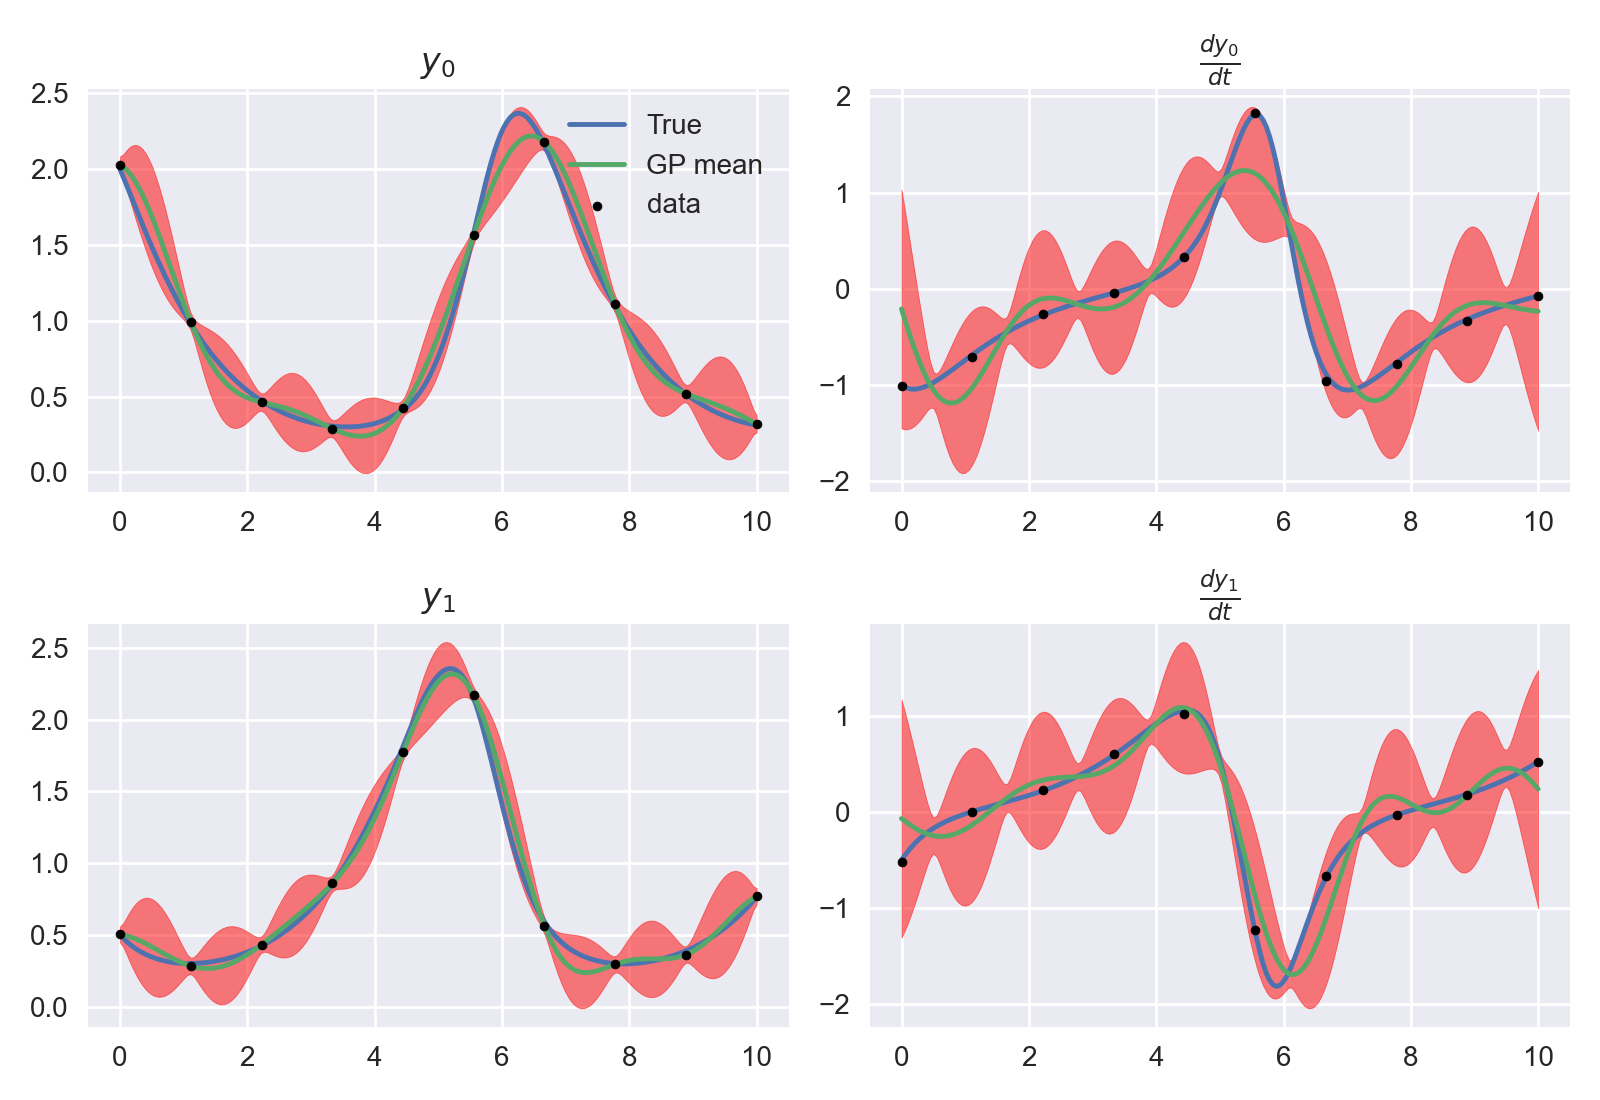

y_0 L2 relative error: 0.07942094662019647
y_1 L2 relative error: 0.05684819926720511


In [11]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.scatter(T_obs,y_noisy[0],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,y_hr[0],label='True')
plt.plot(T_sur,y1,label='GP mean')
plt.fill_between(T_sur,y1-2*np.diag(cov1)[:len(T_sur)]**0.5,
                 y1+2*np.diag(cov1)[:len(T_sur)]**0.5,color='r',alpha=0.5)
plt.title('$y_0$')
plt.legend()
plt.subplot(2,2,2)
plt.scatter(T_obs,dy_noisy[0],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,dy_hr[0])
plt.plot(T_sur,dy1)
plt.fill_between(T_sur,dy1-2*np.diag(cov1)[len(T_sur):]**0.5,
                 dy1+2*np.diag(cov1)[len(T_sur):]**0.5,color='r',alpha=0.5)
plt.title('$\\frac{dy_0}{dt}$')
plt.subplot(2,2,3)
plt.scatter(T_obs,y_noisy[1],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,y_hr[1])
plt.plot(T_sur,y2)
plt.fill_between(T_sur,y2-2*np.diag(cov2)[:len(T_sur)]**0.5,
                 y2+2*np.diag(cov2)[:len(T_sur)]**0.5,color='r',alpha=0.5)
plt.title('$y_1$')
plt.subplot(2,2,4)
plt.scatter(T_obs,dy_noisy[1],c='k',s=10,label='data',zorder=3)
plt.plot(T_sur,dy_hr[1])
plt.plot(T_sur,dy2)
plt.fill_between(T_sur,dy2-2*np.diag(cov2)[len(T_sur):]**0.5,
                 dy2+2*np.diag(cov2)[len(T_sur):]**0.5,color='r',alpha=0.5)
plt.title('$\\frac{dy_1}{dt}$')
plt.tight_layout()
plt.show()

print("y_0 L2 relative error:",la.norm(y_hr[0]-y1)/la.norm(y_hr[0]))
print("y_1 L2 relative error:",la.norm(y_hr[1]-y2)/la.norm(y_hr[1]))

In [13]:
def obj(p):
    fmu = lotka_volterra(T_sur,mu,p[0],p[1],p[2],p[3])
    
    return la.norm(W1@(fmu[0]-dmu[0]))**2 + la.norm(W2@(fmu[1]-dmu[1]))**2

In [14]:
minimize(obj,[1.5,.5,.3,1.2])

      fun: 149.62143624607955
 hess_inv: array([[6.51349267e-05, 6.13462565e-05, 1.27741439e-10, 1.18376904e-10],
       [6.13462565e-05, 6.08010472e-05, 2.17819337e-10, 2.01727548e-10],
       [1.27741498e-10, 2.17819251e-10, 4.15187380e-05, 4.03274630e-05],
       [1.18376965e-10, 2.01727486e-10, 4.03274630e-05, 4.21934517e-05]])
      jac: array([-3.81469727e-06, -7.62939453e-06,  0.00000000e+00, -1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 70
      nit: 7
     njev: 14
   status: 0
  success: True
        x: array([1.04802364, 1.03027441, 0.94262666, 0.92964529])

In [15]:
sol = solve_lv(T_sur,[2,.5], 1.04802364, 1.03027441, 0.94262666, 0.92964529)

<IPython.core.display.Javascript object>


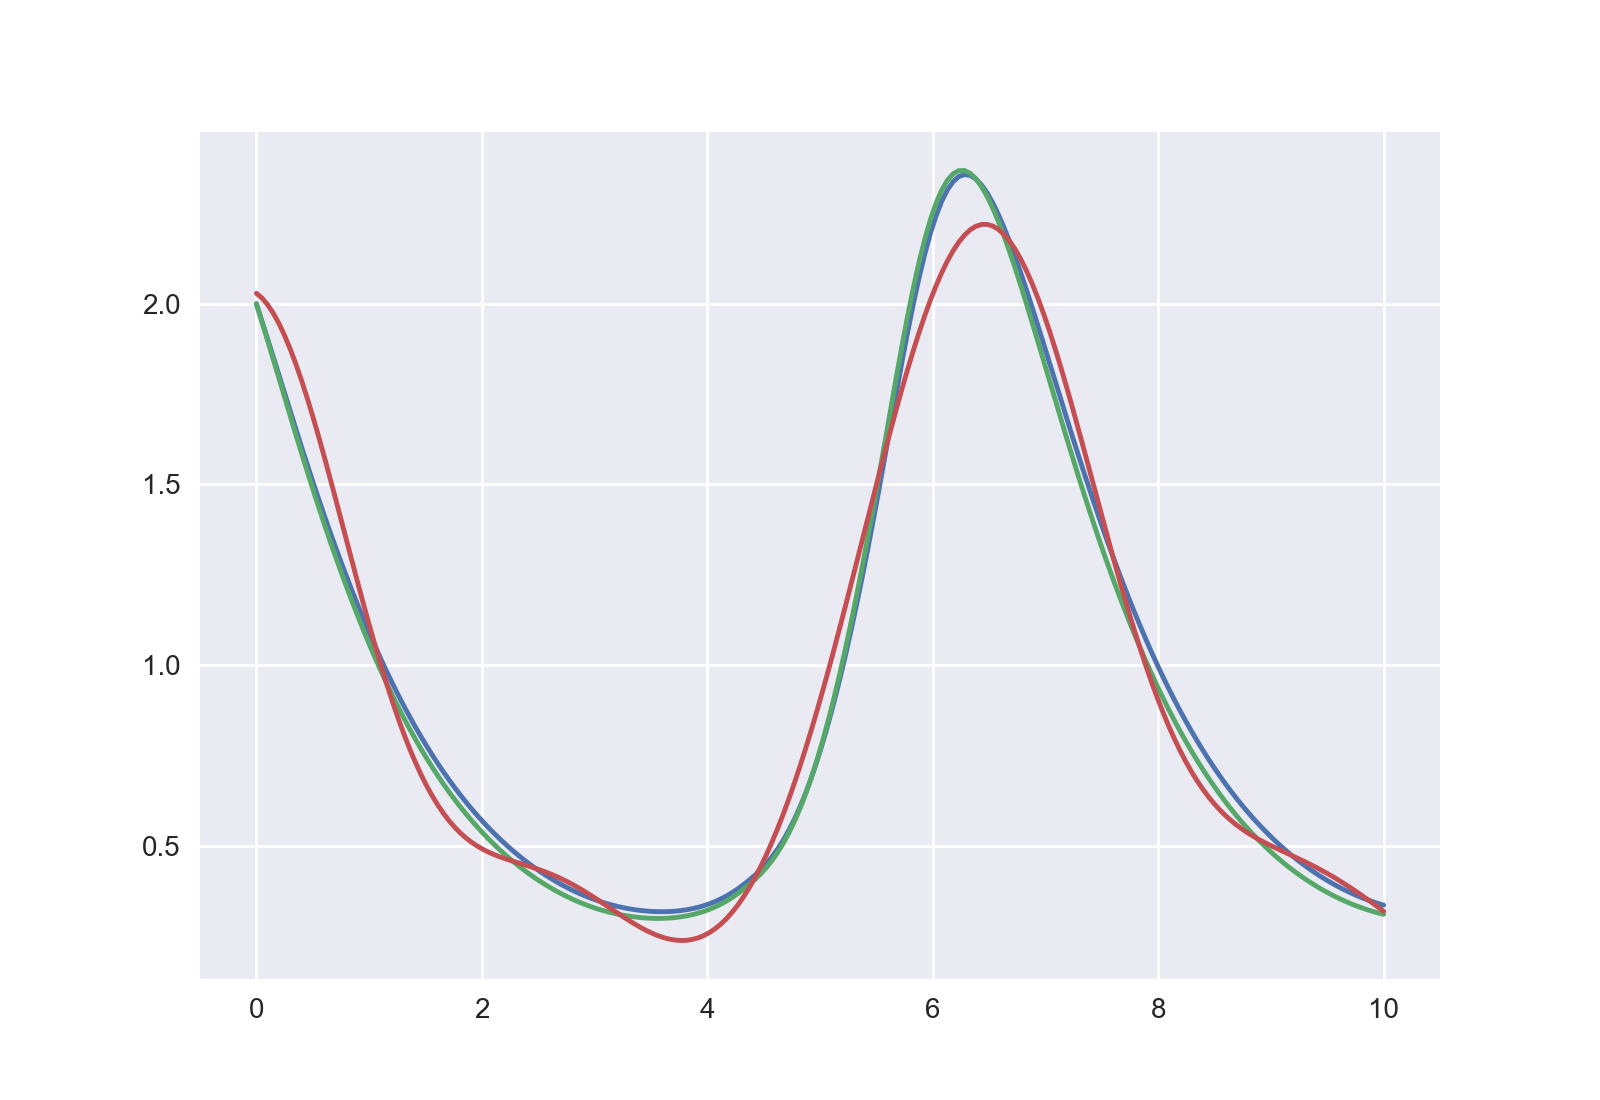

In [16]:
fig = plt.figure()
plt.plot(T_sur,sol[0])
plt.plot(T_sur,y_hr[0])
plt.plot(T_sur,y1)
plt.show()

In [17]:
kernel1 = gpd.DSquareExp() + gpd.DWhiteKernel(sigma1=sigma,sigma2=sigma)
kernel2 = gpd.DSquareExp() + gpd.DWhiteKernel(sigma1=sigma,sigma2=sigma)
gp1 = gpd.DGaussianProcessRegressor(kernel1)
gp2 = gpd.DGaussianProcessRegressor(kernel2)

def obj(p,mu,dmu,W1,W2):
    fmu = lotka_volterra(T_sur,mu,p[0],p[1],p[2],p[3])
    return la.norm(W1@(fmu[0]-dmu[0]))**2 + la.norm(W2@(fmu[1]-dmu[1]))**2

def test_lv_min(n_obs,n_sur,sigma,n_runs):
    T_obs = np.linspace(0,10,n_obs)
    for i in range(n_runs):
        
        y0 = np.random.uniform(.5,2,2)
        p_true = np.random.uniform(.25,1.5,4)
        y = solve_lv(T_obs,y0,p_true[0],p_true[1],p_true[2],p_true[3])
        y_noisy = np.abs(y + sigma*np.random.randn(y.shape[0],y.shape[1]))
        T_sur = np.linspace(0,10,200)
        gp1.fit(T_obs,[],y_noisy[0],[])
        gp2.fit(T_obs,[],y_noisy[1],[])
        y1,dy1,cov1 = gp1.predict(T_sur,T_sur,return_cov=True)
        y2,dy2,cov2 = gp2.predict(T_sur,T_sur,return_cov=True)
        mu = np.array([y1,y2])
        dmu = np.array([dy1,dy2])
        y_hr = solve_lv(T_sur,y0,p_true[0],p_true[1],p_true[2],p_true[3])
        
        # Get weight matrix for precision matrix
        # compute eigendecompositions
        e1,v1 = la.eig(cov1[len(T_sur):,len(T_sur):])
        e2,v2 = la.eig(cov2[len(T_sur):,len(T_sur):])

        # build weight matrices
        W1 = np.real(np.diag(np.sqrt(1/e1))@(v1.T))
        W2 = np.real(np.diag(np.sqrt(1/e2))@(v2.T))
        
        p_guess = np.abs(p_true + .5*np.random.randn(4))
        p_hat = minimize(obj,p_guess,args=(mu,dmu,W1,W2)).x
        
        print("i:",i)
        print('p_true:',p_true)
        print('p_hat:',p_hat)
        rel_err = la.norm(p_true-p_hat)/la.norm(p_true)
        print("relative error:",rel_err)

        sol = solve_lv(T_sur,y0,p_hat[0],p_hat[1],p_hat[2],p_hat[3])
        fig = plt.figure()
        plt.subplot(2,1,1)
        plt.plot(T_sur,y_hr[0],label='True solution')
        plt.plot(T_sur,sol[0],label='Estimated')
        plt.scatter(T_obs,y_noisy[0],c='k',label='noisy data')
        plt.legend()
        plt.subplot(2,1,2)
        plt.plot(T_sur,y_hr[1])
        plt.plot(T_sur,sol[1])
        plt.scatter(T_obs,y_noisy[1],c='k',label='noisy data')
        fig.suptitle(f"Lotka-Volterra solutions with parameters\np_true = {str(p_true)}\np_opt ={str(p_hat)}\nrelative error = {rel_err:.4f}")
        fig.tight_layout(rect=[0, 0.03, 1, 1])
        plt.show()

i: 0
p_true: [0.897268   1.27887329 1.16528128 0.33632034]
p_hat: [0.94487667 1.23229483 1.07321311 0.28626837]
relative error: 0.06278202171392268


<IPython.core.display.Javascript object>


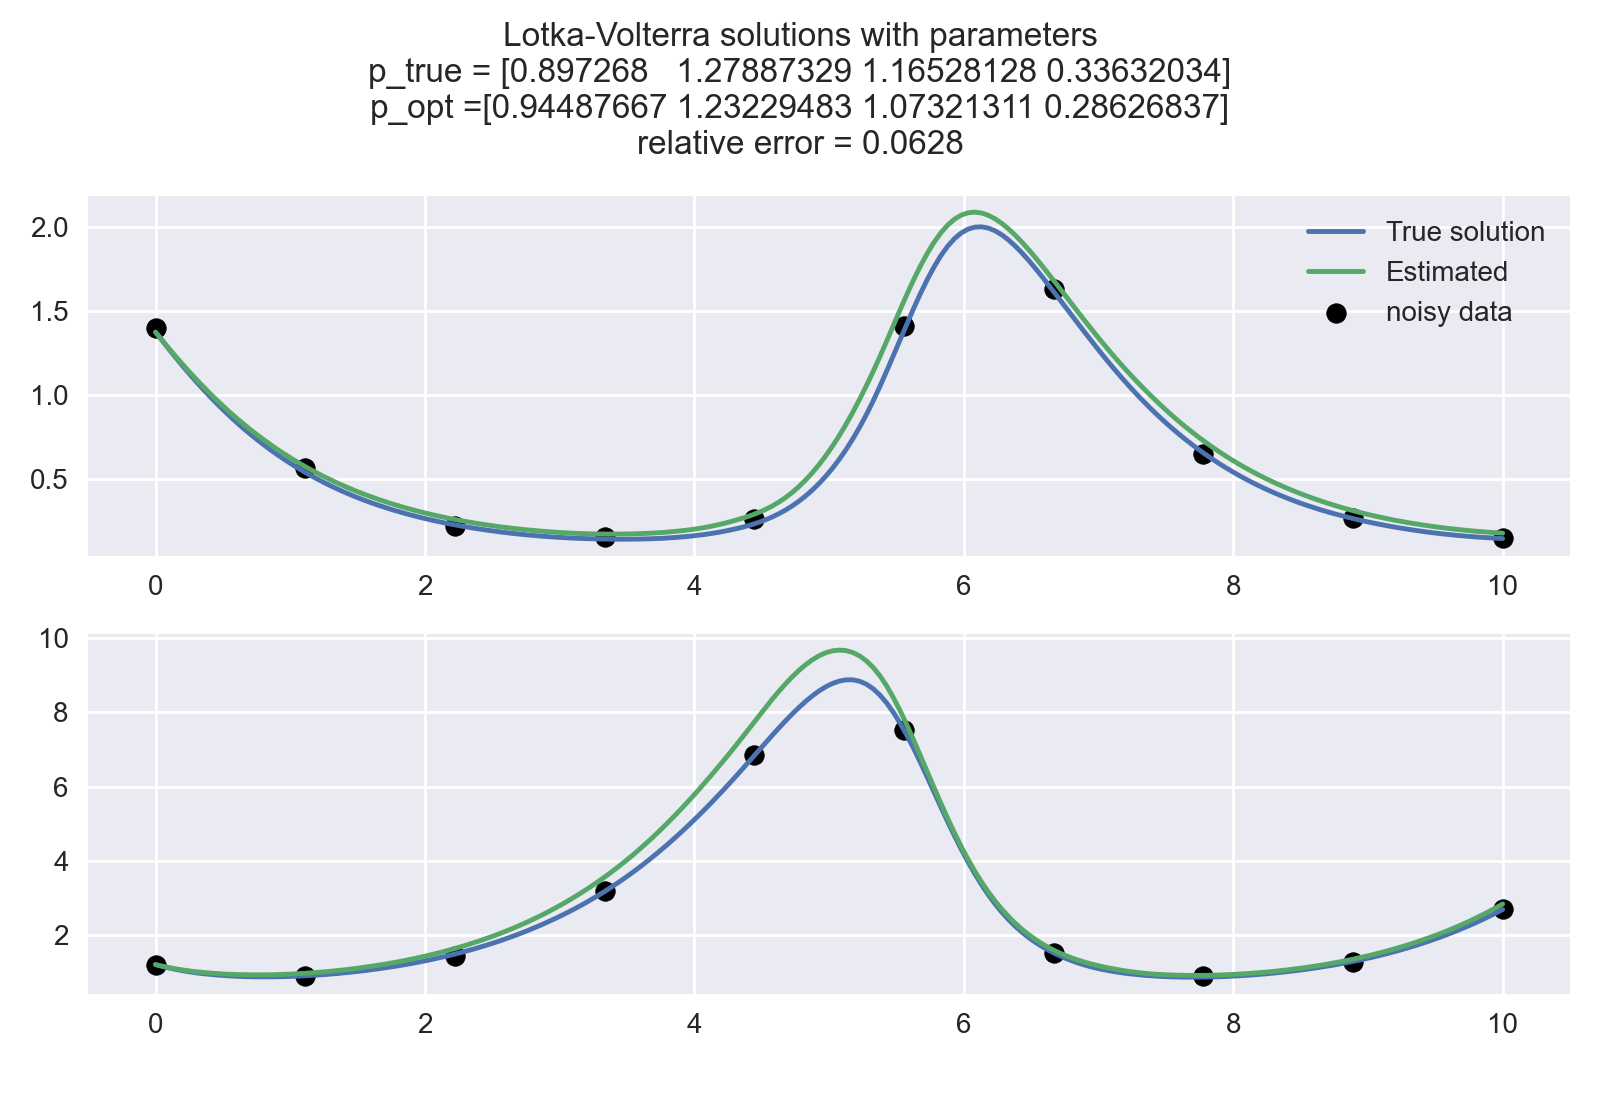

i: 1
p_true: [0.44326851 0.73587437 1.05951768 1.31037389]
p_hat: [0.4443061  0.72010629 1.03963732 1.2644225 ]
relative error: 0.027757301937864975


<IPython.core.display.Javascript object>


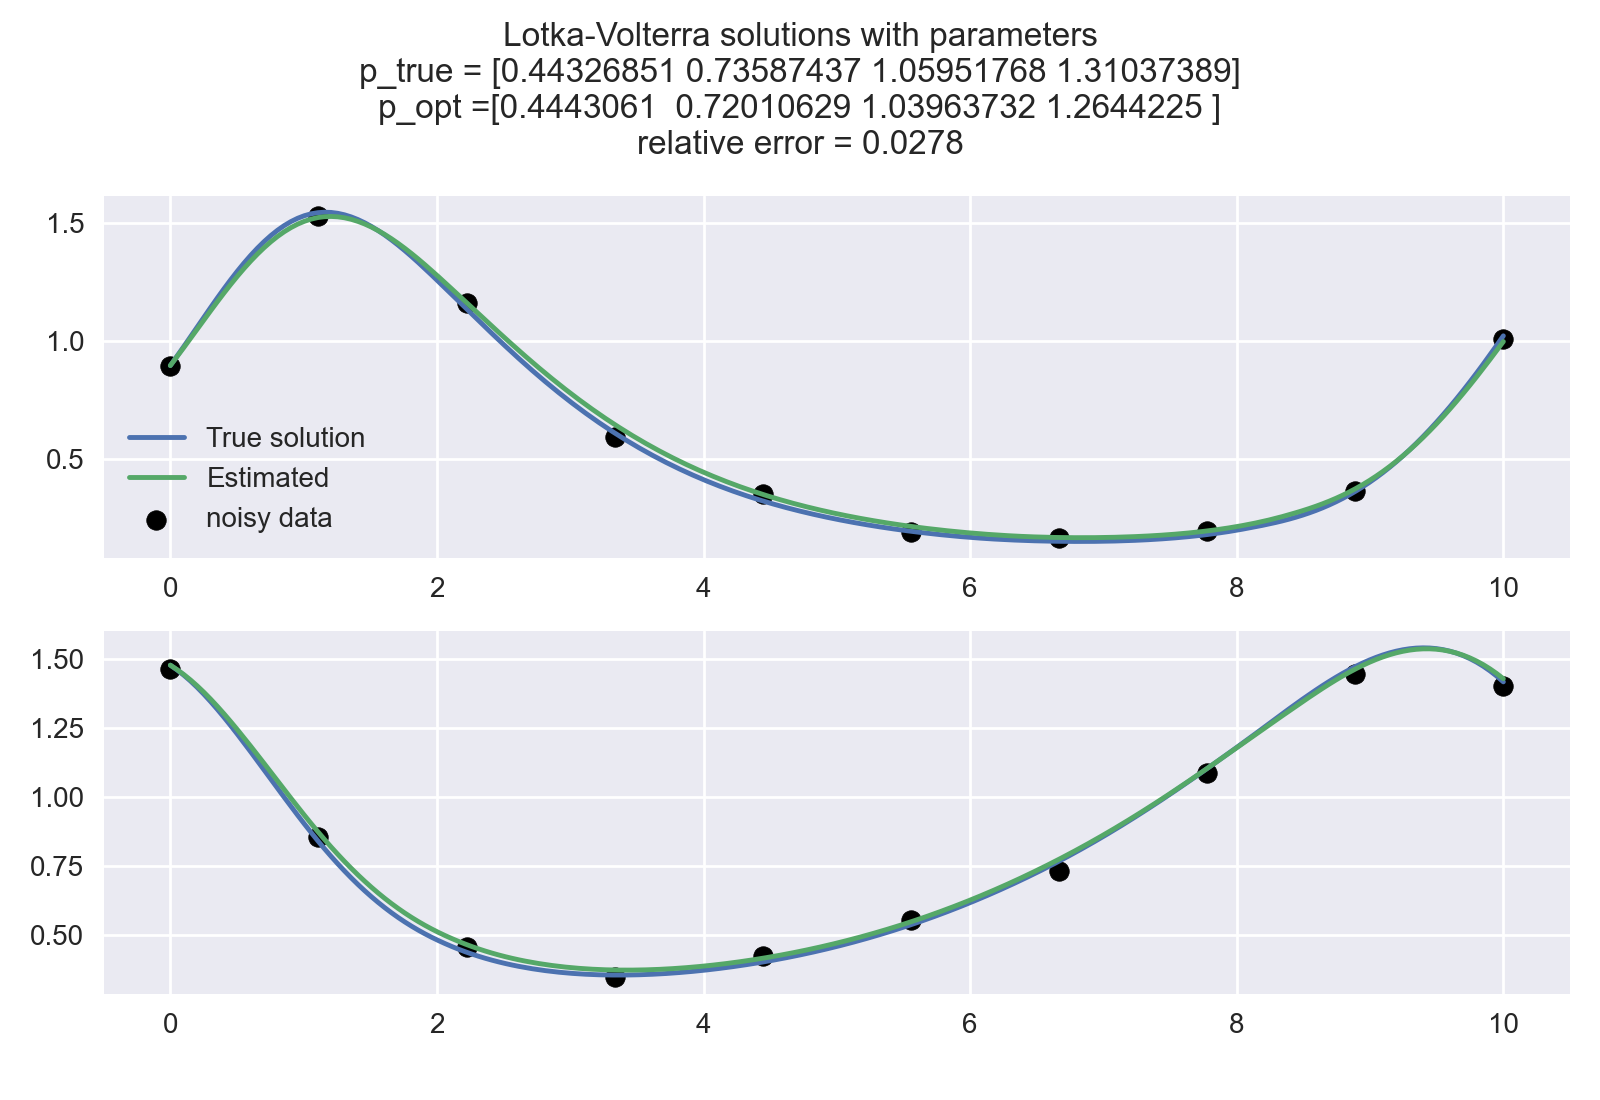

i: 2
p_true: [1.2823738  0.63175023 1.27909739 0.94613805]
p_hat: [1.18625769 0.57482277 1.27641759 0.93078018]
relative error: 0.05273396324222165


<IPython.core.display.Javascript object>


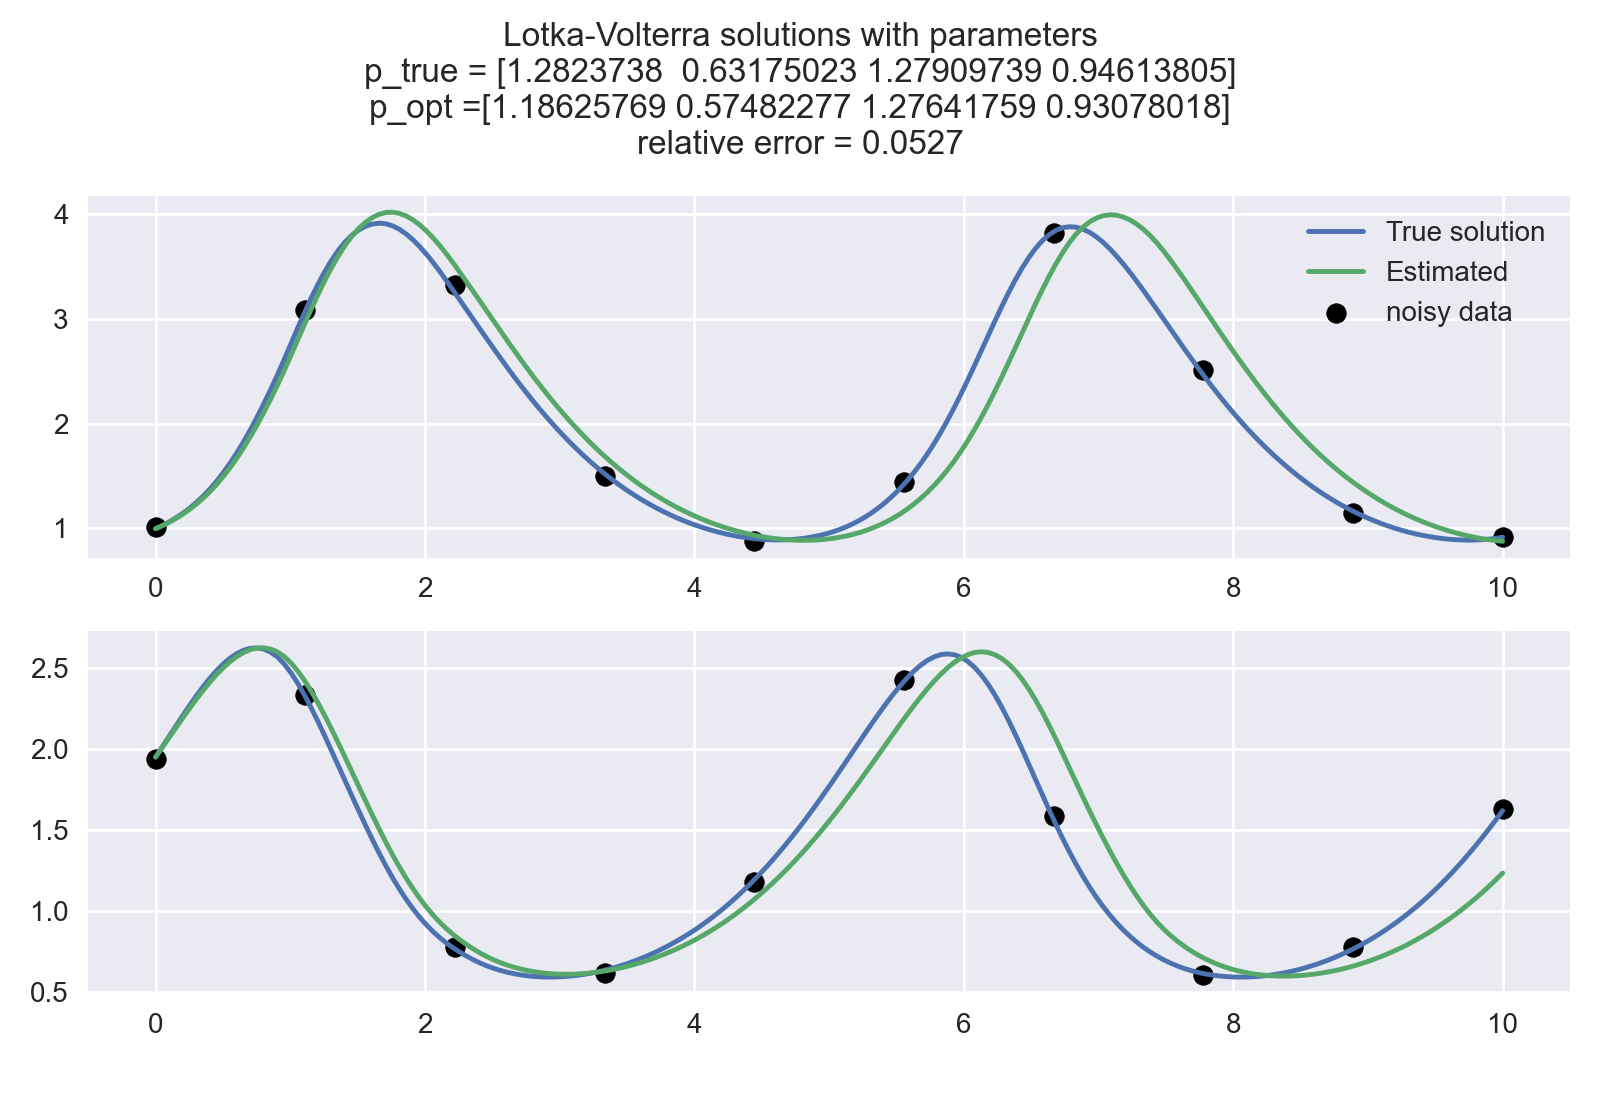

i: 3
p_true: [0.58334986 0.72800882 0.87944809 1.07145348]
p_hat: [0.60293516 0.73878519 0.87811225 1.05607188]
relative error: 0.0162599155574035


<IPython.core.display.Javascript object>


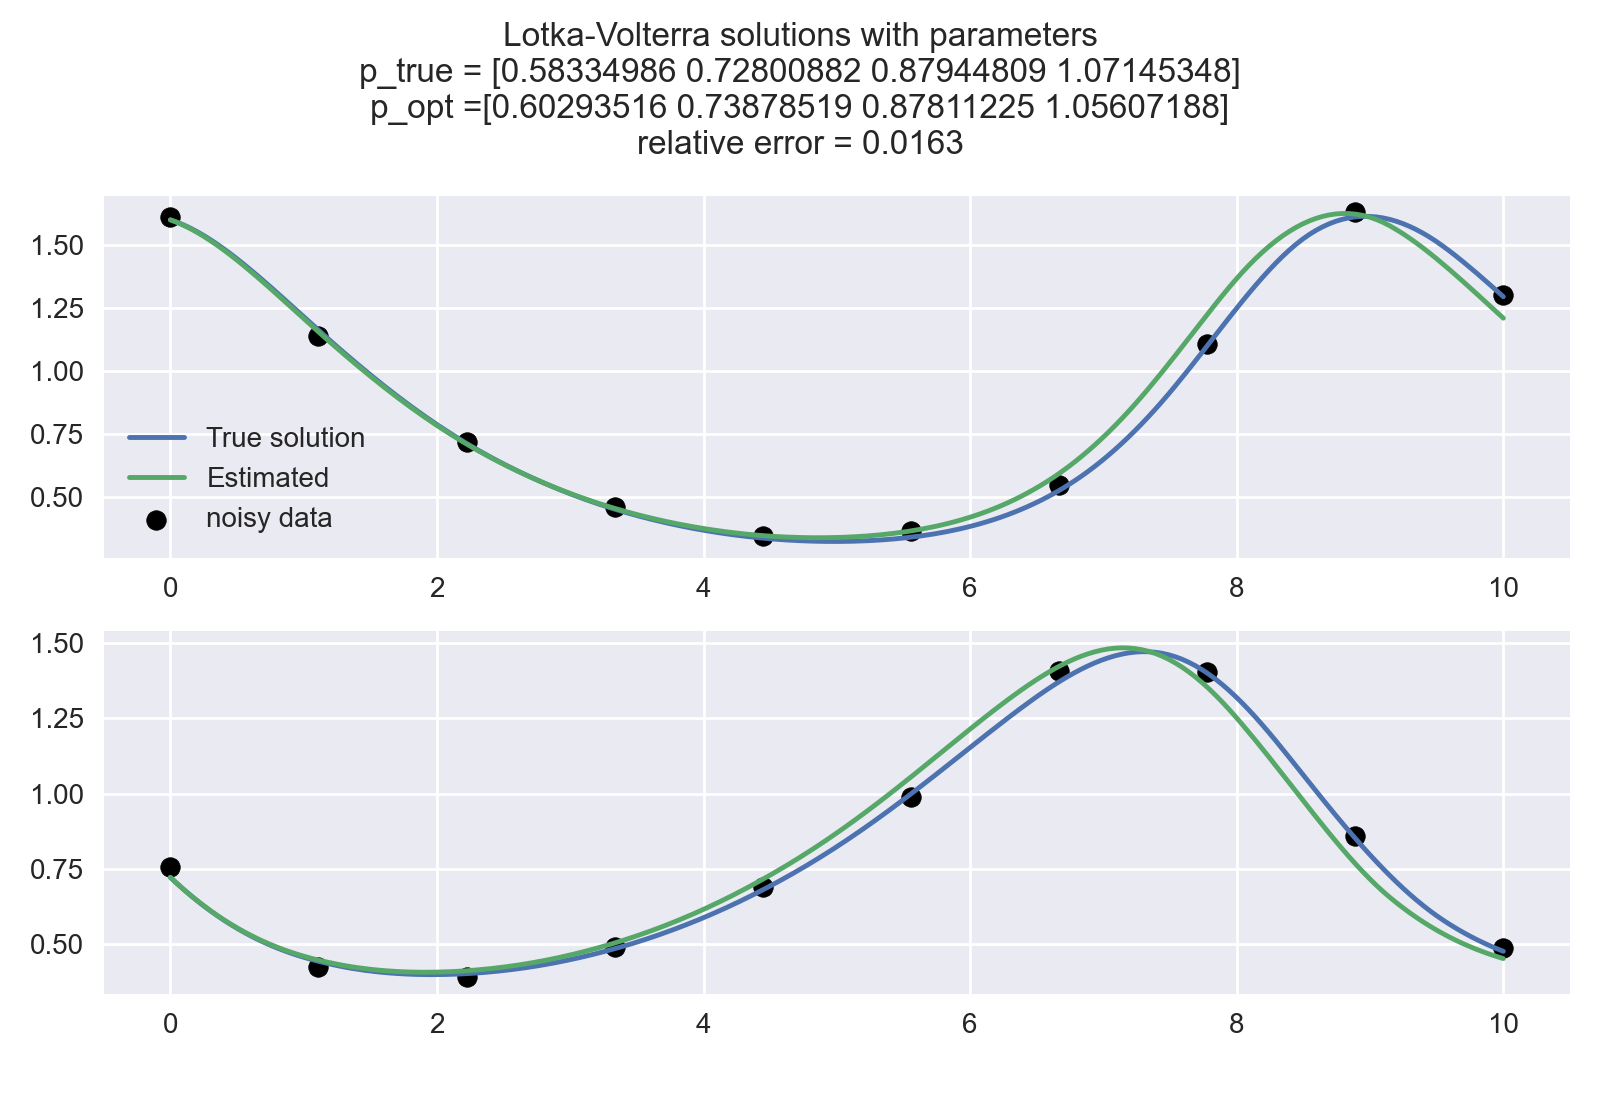

i: 4
p_true: [1.17032352 0.40965277 1.01192615 0.32790535]
p_hat: [1.17092287 0.40623172 0.98287984 0.31618584]
relative error: 0.019289573413253


<IPython.core.display.Javascript object>


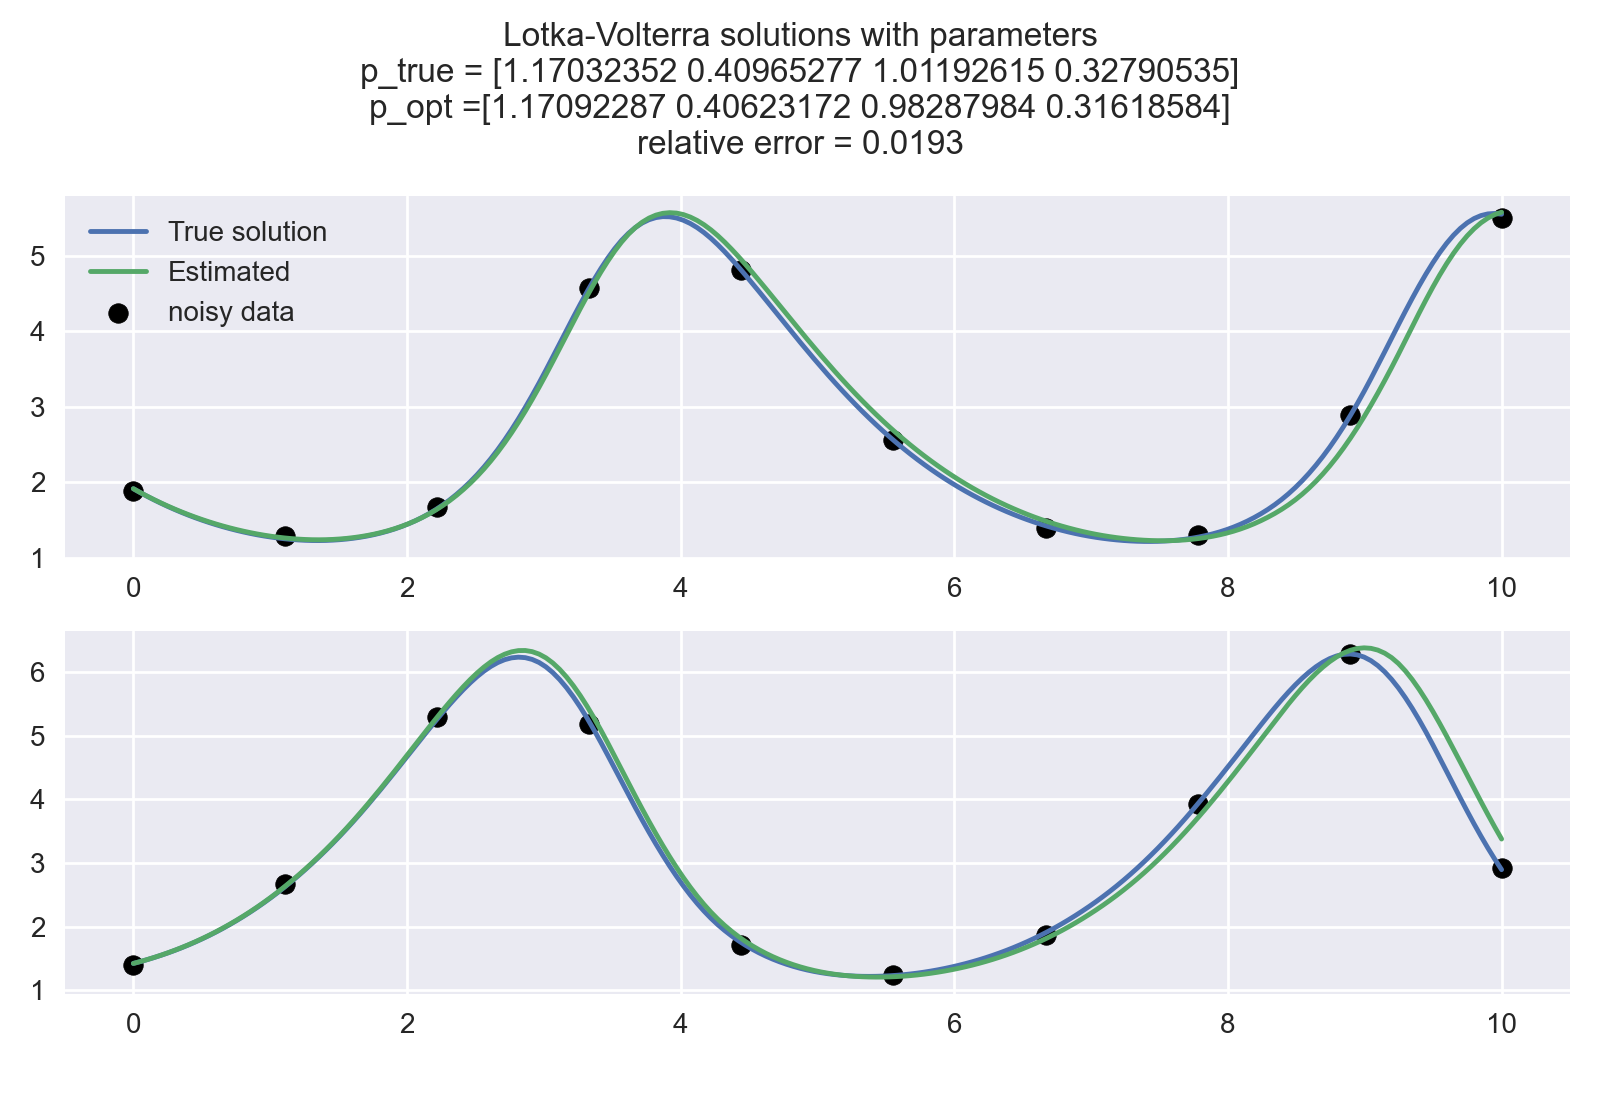

i: 5
p_true: [0.25629938 0.78999131 1.36753321 1.19519645]
p_hat: [0.2556342  0.77523446 1.37106194 1.20068005]
relative error: 0.008085263131236059


<IPython.core.display.Javascript object>


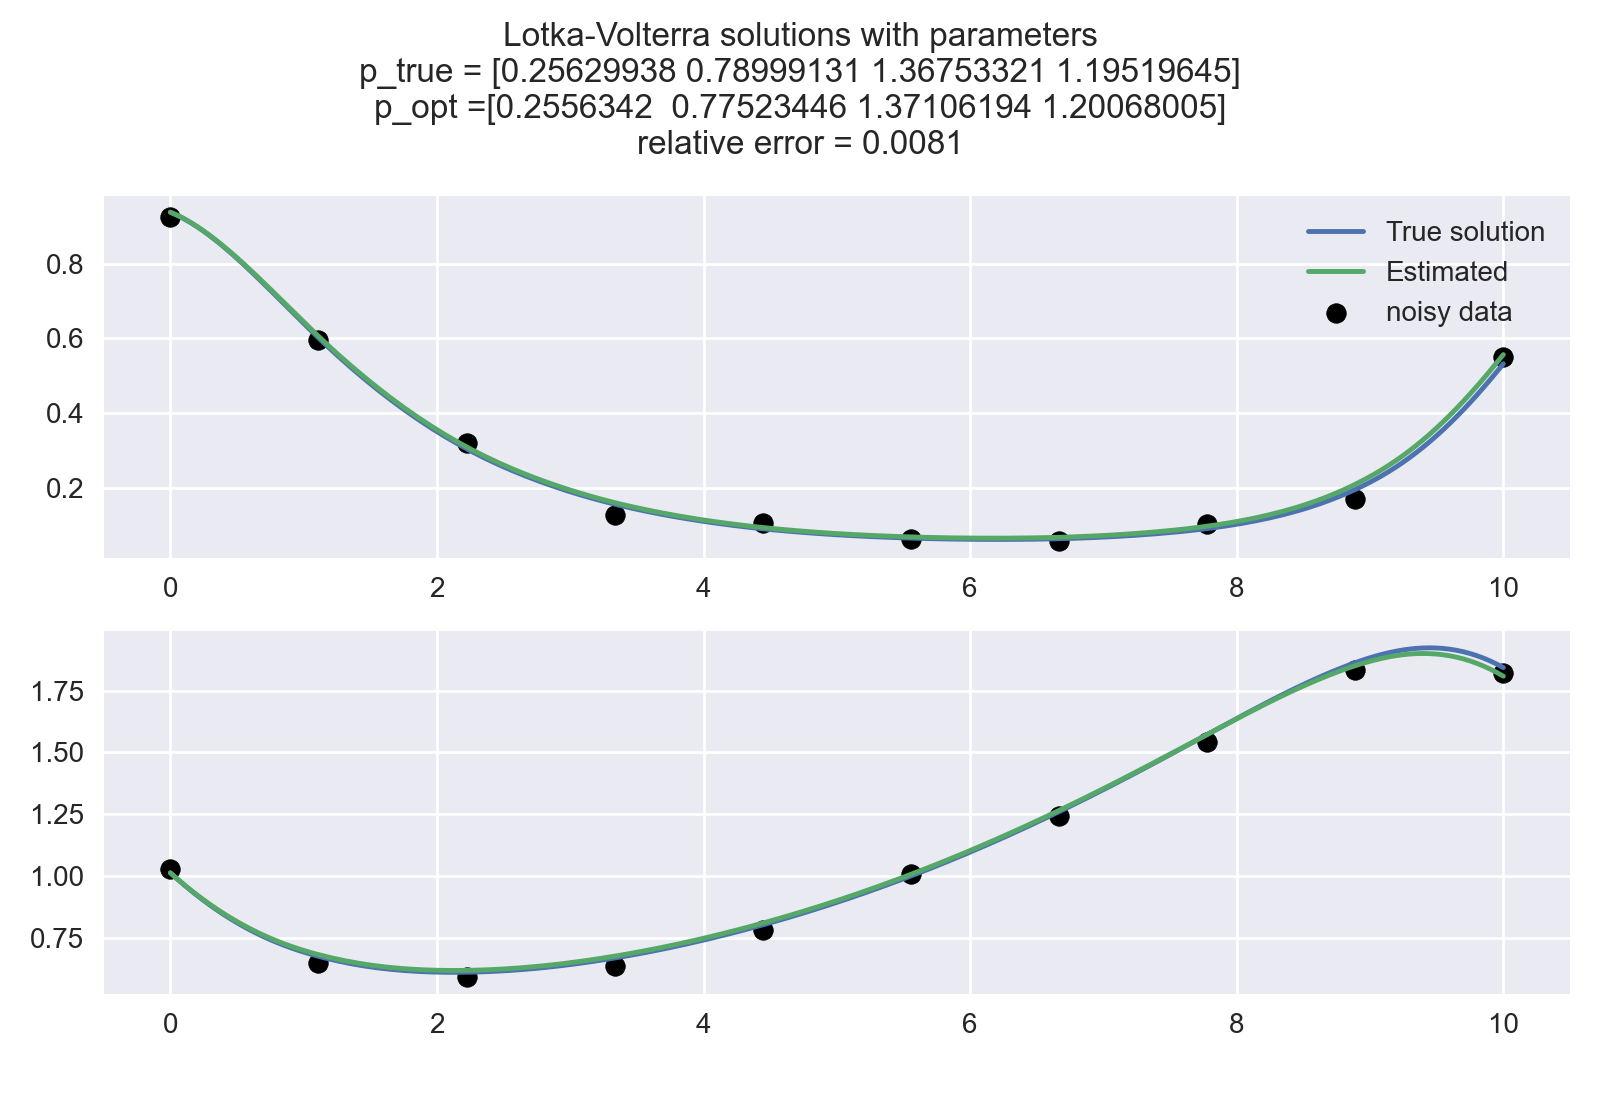

i: 6
p_true: [0.54723048 0.90536249 0.84965615 0.96826793]
p_hat: [0.55353067 0.86289769 0.78999975 0.79622365]
relative error: 0.112234813146103


<IPython.core.display.Javascript object>


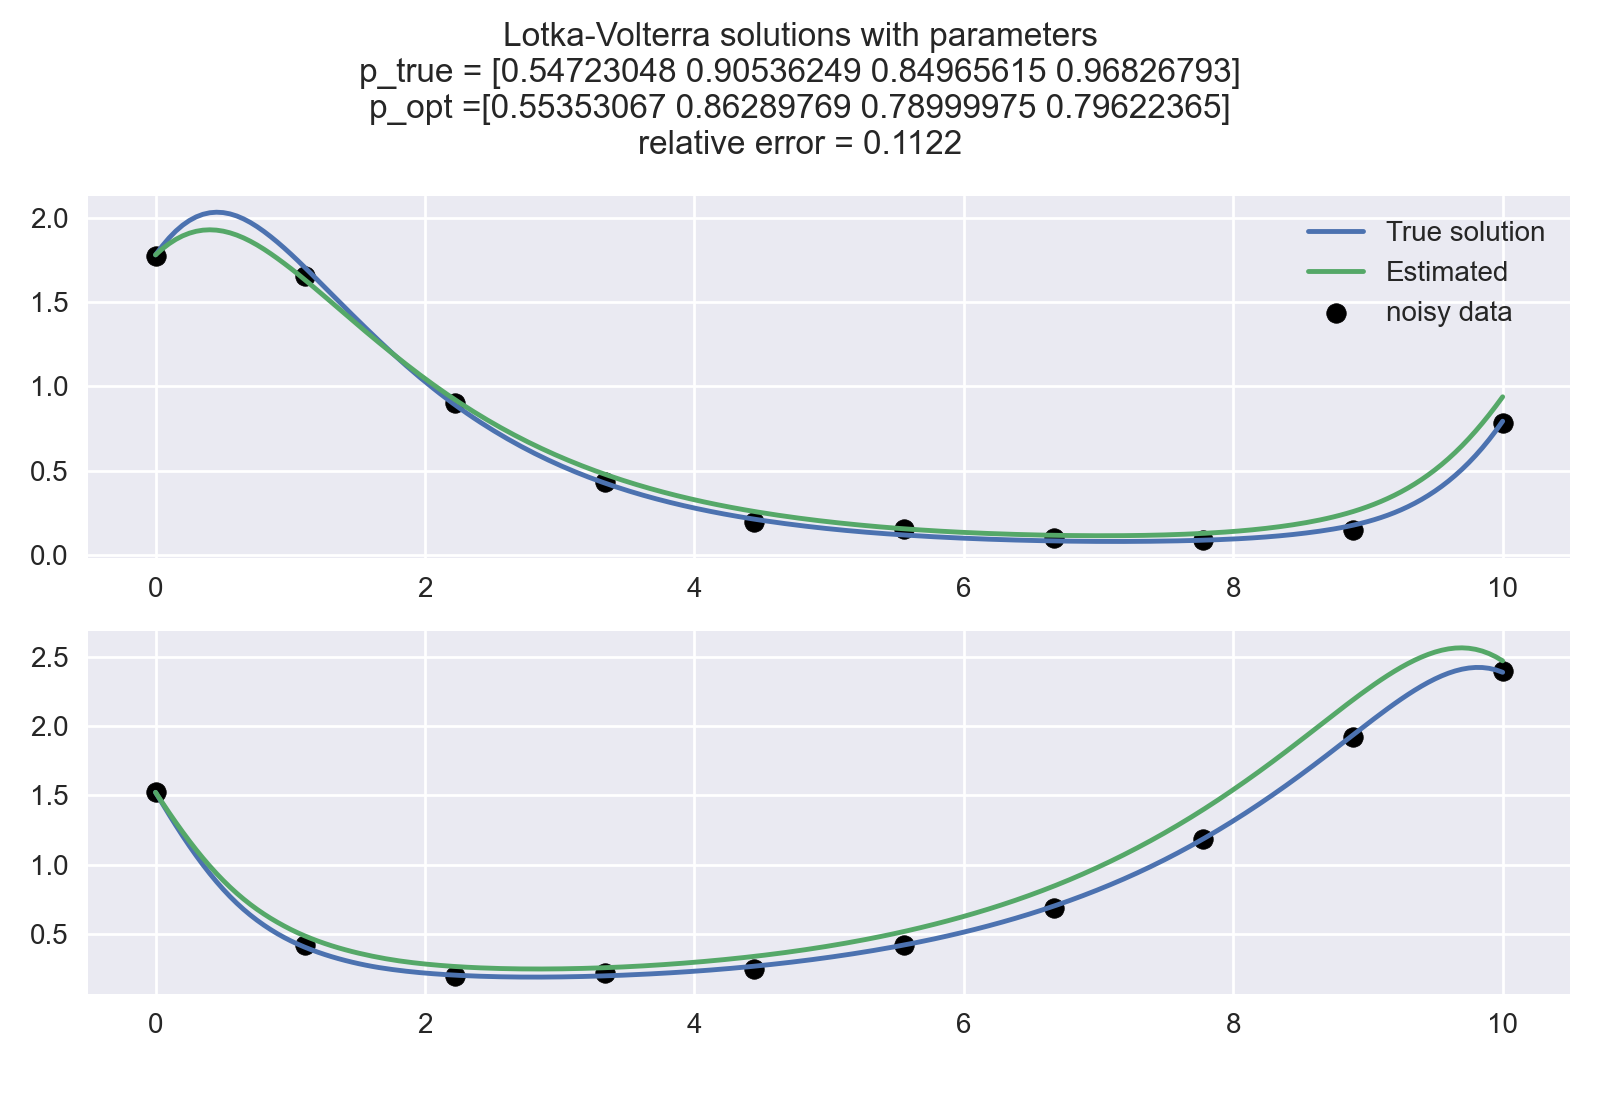

i: 7
p_true: [1.06572787 0.90236373 1.03974116 1.09875097]
p_hat: [1.0711653  0.90725647 1.00618735 1.07377473]
relative error: 0.02062626173029695


<IPython.core.display.Javascript object>


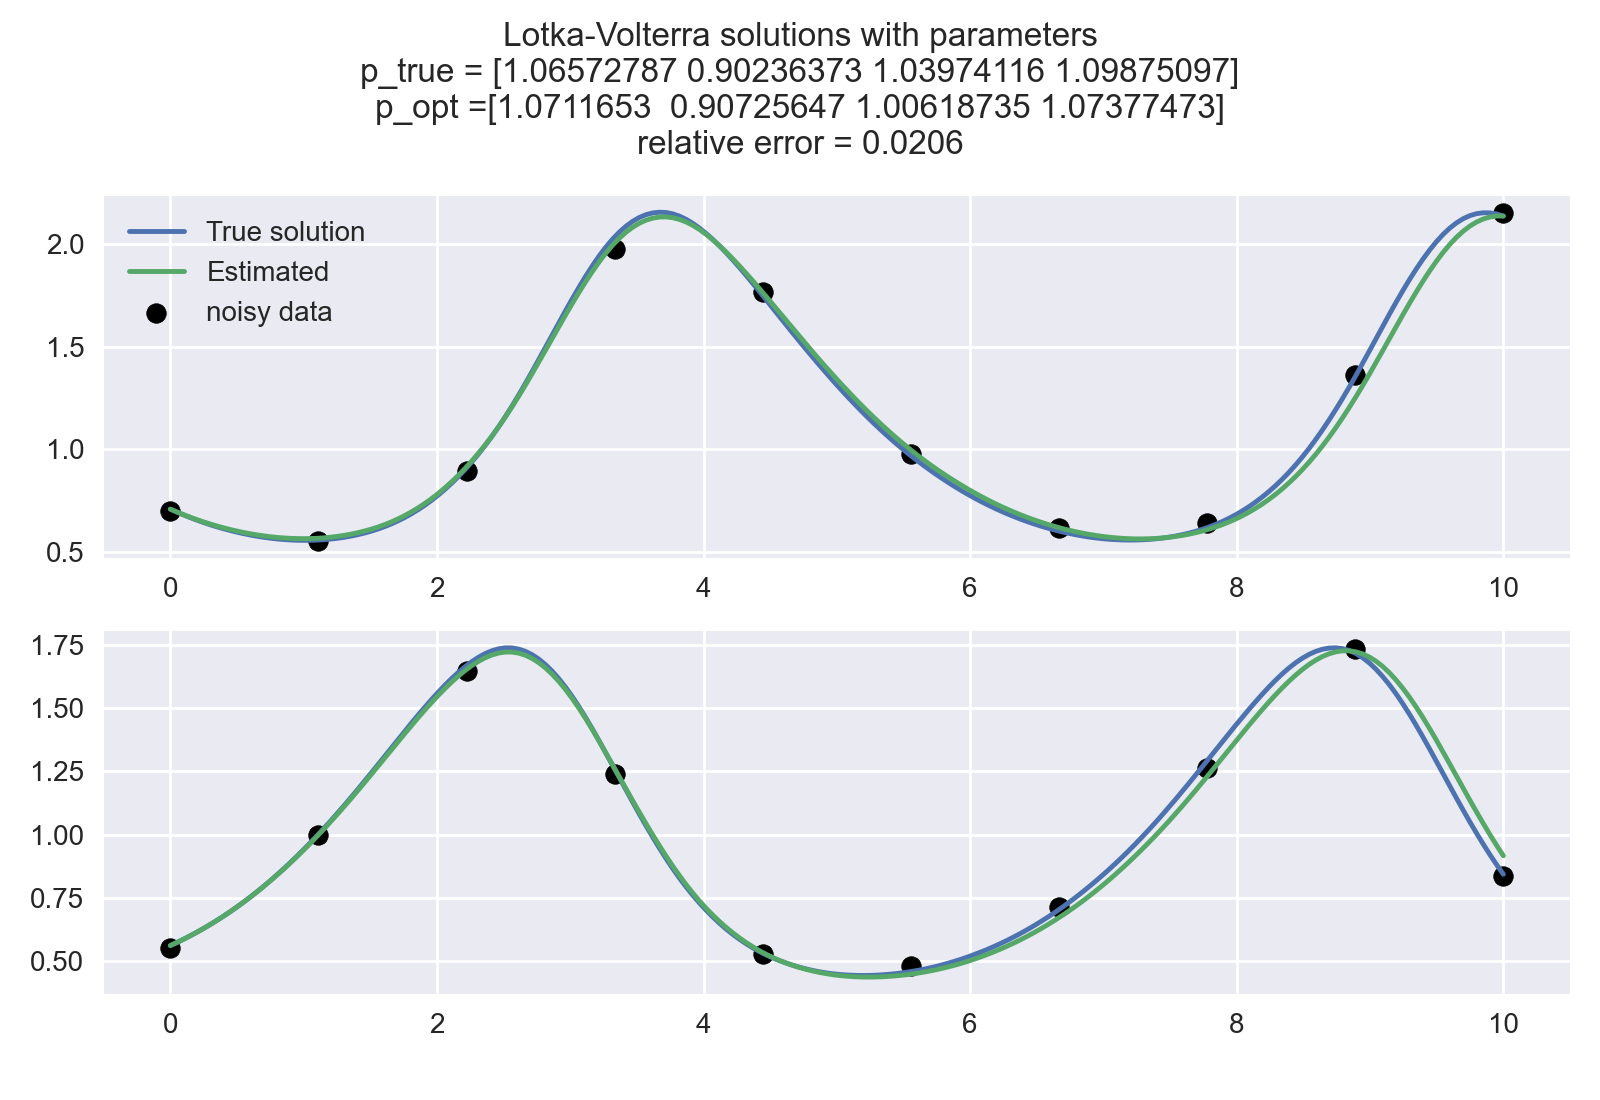

i: 8
p_true: [1.29971657 0.8339197  0.5526336  0.30662149]
p_hat: [1.29154053 0.81450702 0.54553915 0.29787647]
relative error: 0.014314870199667753


<IPython.core.display.Javascript object>


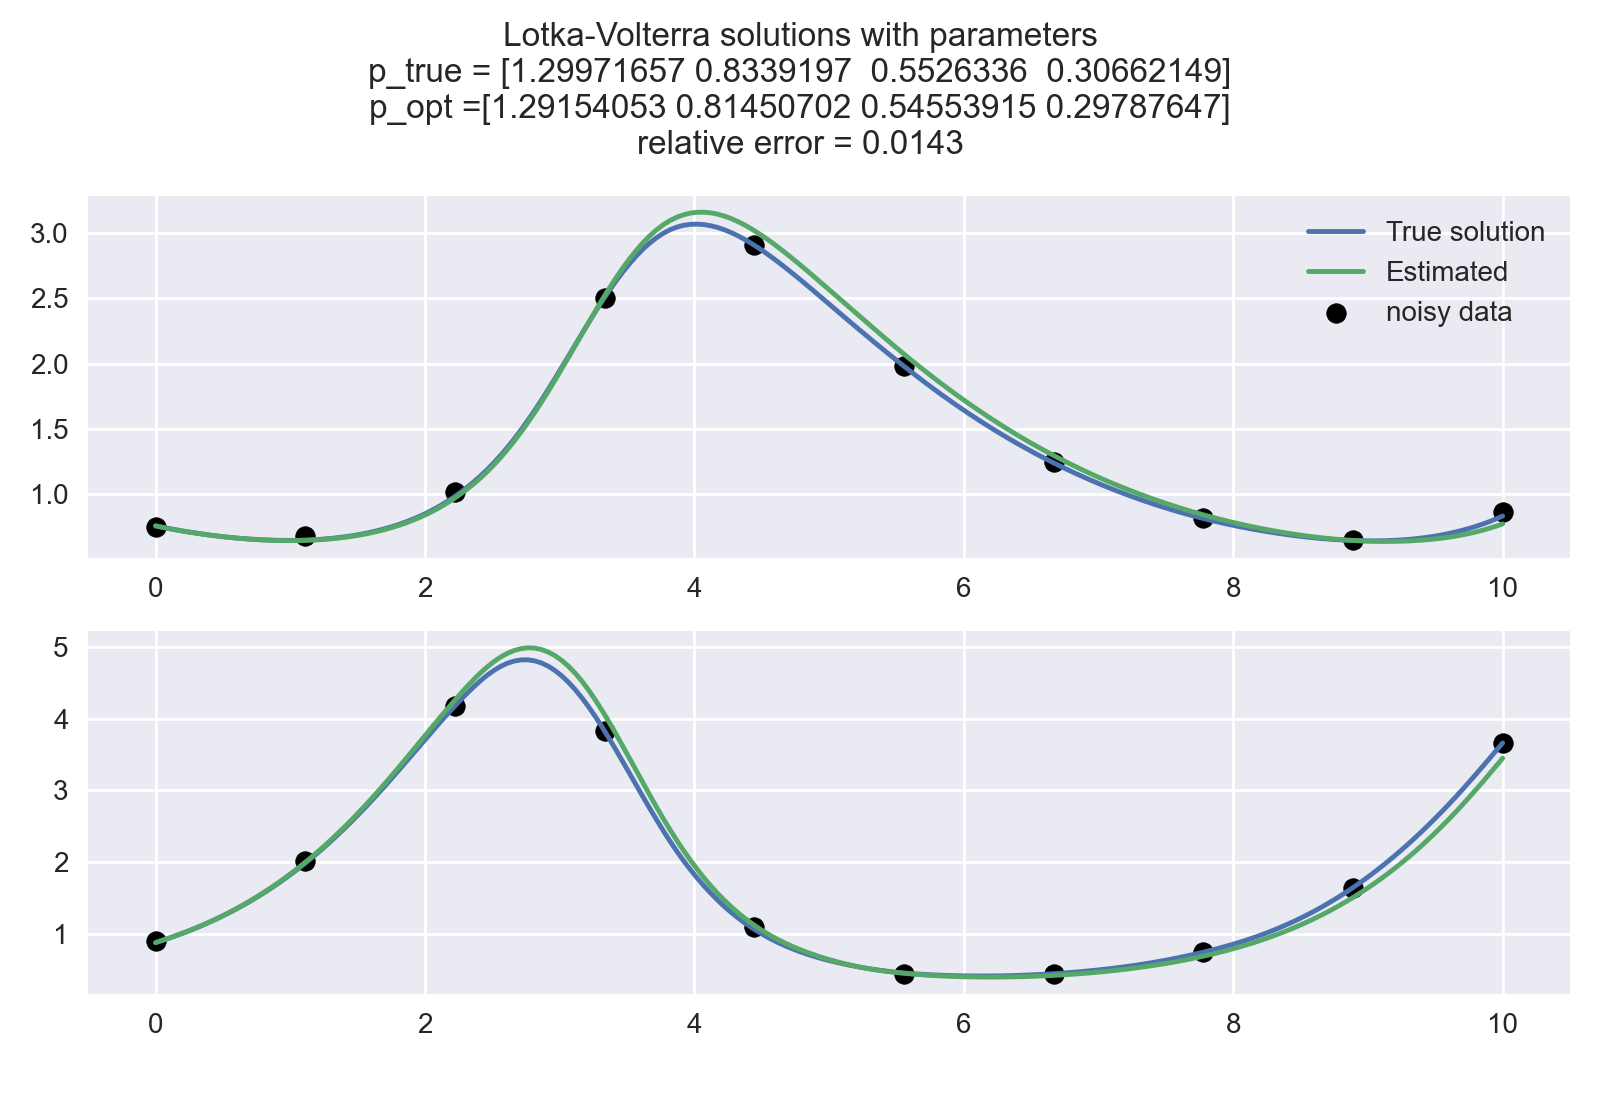

i: 9
p_true: [0.6914312  1.10900739 1.03488309 0.72970877]
p_hat: [0.44570088 0.72384381 0.85897454 0.59982282]
relative error: 0.27834077601507295


<IPython.core.display.Javascript object>


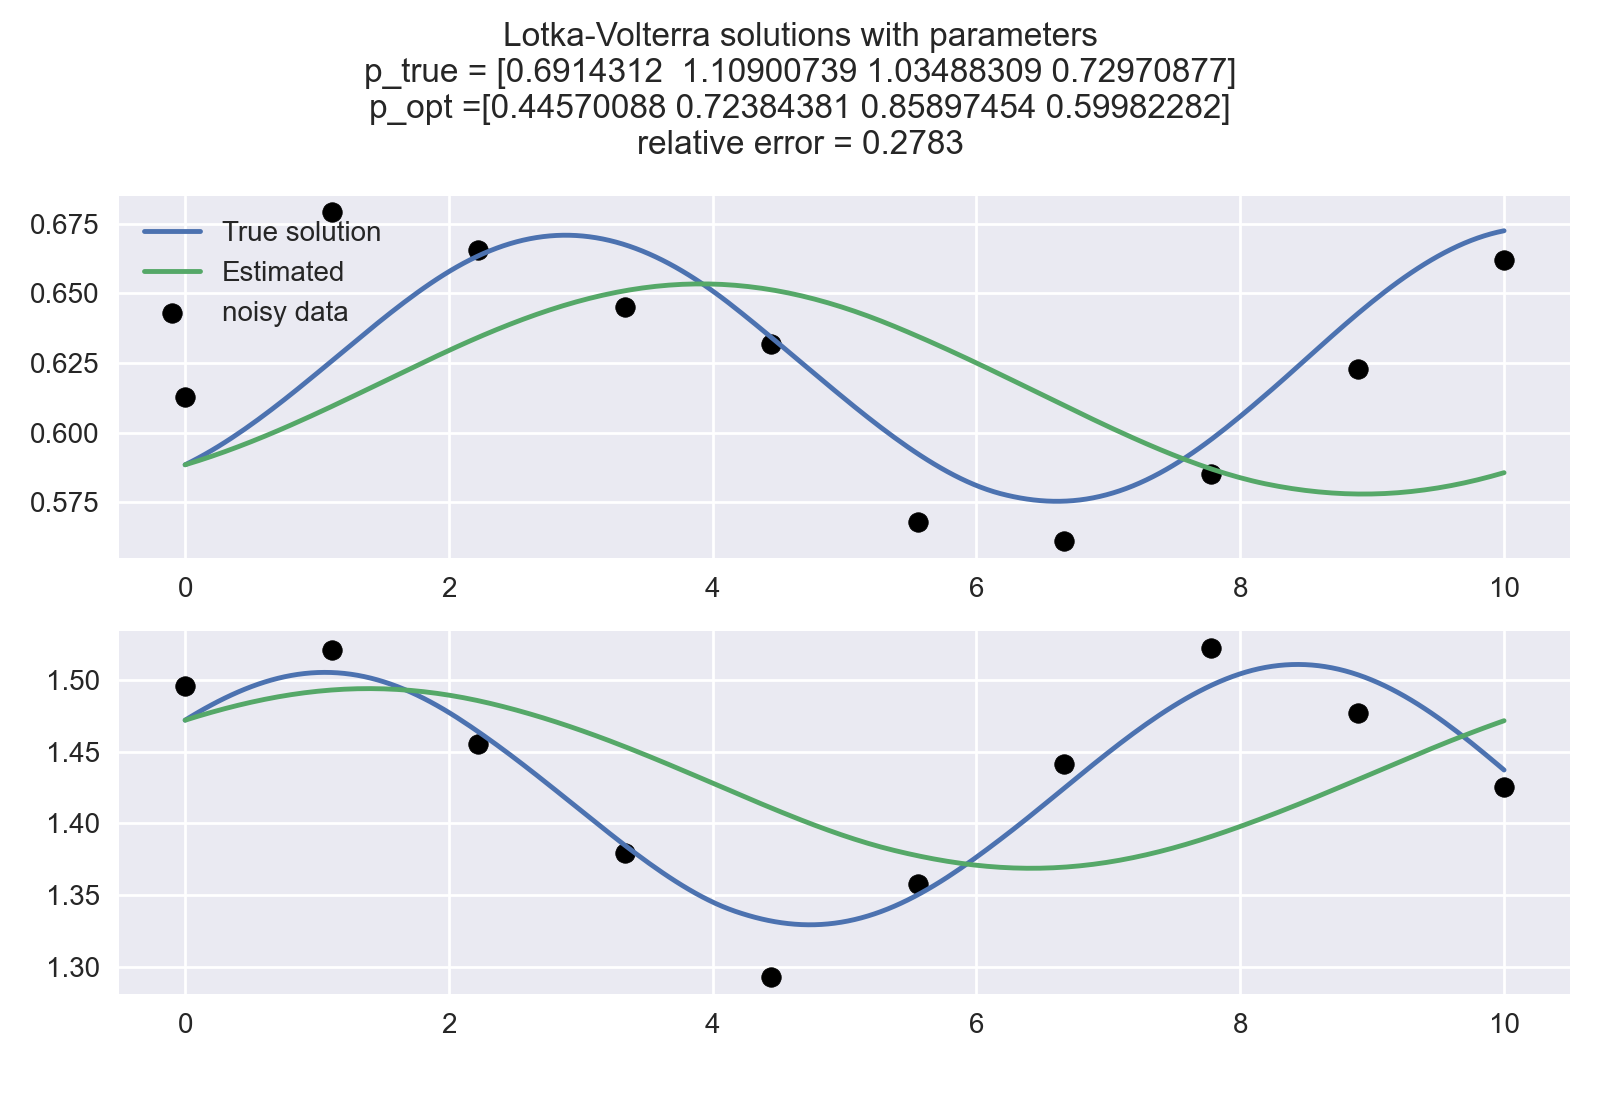

In [18]:
test_lv_min(10,200,.02,10)

In [6]:
def build_A(mu):
    n = mu.size
    A = np.zeros((n,4))
    A[:n//2,3] = mu[0]*mu[1]
    A[:n//2,2] = -mu[0]
    A[n//2:,1] = -mu[0]*mu[1]
    A[n//2:,0] = mu[1]
    return A

In [7]:
def prec_post(mu,dSigma):
    A = build_A(mu)
    B = la.solve(dSigma,A)
    return A.T@B

def p_post(mu,dmu,dSigma):
    A = build_A(mu)
    prec = prec_post(mu,dSigma)
    z = A.T@la.solve(dSigma,dmu.flatten())
    return la.solve(prec,z), prec

In [23]:
dcov1 = cov1[n_sur:,n_sur:]
dcov2 = cov2[n_sur:,n_sur:]
dSigma = np.block([[dcov1,np.zeros_like(dcov1)],[np.zeros_like(dcov2),dcov2]])

In [24]:
la.inv(prec_post(mu,dSigma))

array([[ 1.30269893e-04,  1.22692534e-04, -0.00000000e+00,
        -0.00000000e+00],
       [ 1.22692534e-04,  1.21602085e-04, -0.00000000e+00,
        -0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  8.30347608e-05,
         8.06524127e-05],
       [ 0.00000000e+00,  0.00000000e+00,  8.06524127e-05,
         8.43845772e-05]])

In [25]:
p_post(mu,dmu,dSigma)

(array([1.04802394, 1.0302747 , 0.94262686, 0.9296455 ]),
 array([[ 154389.32940264, -155773.79290375,       0.        ,
               0.        ],
        [-155773.79290375,  165394.21455648,       0.        ,
               0.        ],
        [      0.        ,       0.        ,  168082.86960251,
         -160648.89362199],
        [      0.        ,       0.        , -160648.89362199,
          165394.21455648]]))

In [17]:
def gauss_density(X,Y,mu,Sigma):
    arr = np.array([X.flatten(),Y.flatten()])
    return stats.multivariate_normal.pdf(arr.T,mean=mu,cov=Sigma).reshape(X.shape)

def lv_post(p_true,y0,sigma,n_obs,n_sur,seed=2021):
    # generate data
    T_obs = np.linspace(0,10,n_obs)
    y = solve_lv(T_obs,y0,p_true[0],p_true[1],p_true[2],p_true[3])

    # set random seed
    np.random.seed(seed)

    # add noise
    y_noisy = y
    y_noisy[0] = np.abs(y[0] + sigma*np.mean(y[0])*np.random.randn(y.shape[1]))
    y_noisy[1] = np.abs(y[1] + sigma*np.mean(y[1])*np.random.randn(y.shape[1]))
    
    # build GPs
    kernel1 = gpd.DSquareExp() + gpd.DWhiteKernel(sigma1=sigma,sigma2=10*sigma)
    kernel2 = gpd.DSquareExp() + gpd.DWhiteKernel(sigma1=sigma,sigma2=10*sigma)
    gp1 = gpd.DGaussianProcessRegressor(kernel1)
    gp2 = gpd.DGaussianProcessRegressor(kernel2)
    
    # fit GPs
    gp1.fit(T_obs,[],y_noisy[0],[])
    gp2.fit(T_obs,[],y_noisy[1],[])
    
    # compute GP predictive mean and covariance at surrogate times
    T_sur = np.linspace(0,10,n_sur)
    y1,dy1,cov1 = gp1.predict(T_sur,T_sur,return_cov=True)
    y2,dy2,cov2 = gp2.predict(T_sur,T_sur,return_cov=True)
    mu = np.array([y1,y2])
    dmu = np.array([dy1,dy2])
    
    # extract covariance for derivative only
    dcov1 = cov1[n_sur:,n_sur:]
    dcov2 = cov2[n_sur:,n_sur:]
    
    # put in block form
    dSigma = np.block([[dcov1,np.zeros_like(dcov1)],[np.zeros_like(dcov2),dcov2]])
    
    # compute posterior
    p_hat,prec = p_post(mu,dmu,dSigma)
    cov = la.inv(prec)
    std = np.diag(cov)**0.5
    print(f'Settings: n_obs={n_obs}, n_sur={n_sur}, sigma={sigma}, y0={y0}')
    print('p_true:',p_true)
    print('p_hat:',p_hat)
    print('p_std',std)
    print('\n')
    fig = plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    xl = min(p_hat[0]-3*std[0],p_true[0]-.05)
    xu = max(p_hat[0]+3*std[0],p_true[0]+.05)
    yl = min(p_hat[1]-3*std[1],p_true[1]-.05)
    yu = max(p_hat[1]+3*std[1],p_true[1]+.05)
    x = np.linspace(xl,xu,200)
    y = np.linspace(yl,yu,200)
    X,Y = np.meshgrid(x,y,indexing='ij')
    plt.pcolormesh(X,Y,gauss_density(X,Y,p_hat[:2],cov[:2,:2]),shading='auto',label='posterior density')
    plt.plot(p_true[0],p_true[1],'ro',label='true $p$') 
    plt.title('$p_0$ vs $p_1$')
    plt.xlabel('$p_0$')
    plt.ylabel('$p_1$')
    plt.legend()
    
    plt.subplot(1,2,2)
    xl = min(p_hat[2]-3*std[2],p_true[2]-.05)
    xu = max(p_hat[2]+3*std[2],p_true[2]+.05)
    yl = min(p_hat[3]-3*std[3],p_true[3]-.05)
    yu = max(p_hat[3]+3*std[3],p_true[3]+.05)
    x = np.linspace(xl,xu,200)
    y = np.linspace(yl,yu,200)
    X,Y = np.meshgrid(x,y,indexing='ij')
    
    plt.pcolormesh(X,Y,gauss_density(X,Y,p_hat[2:],cov[2:,2:]),shading='auto')
    plt.plot(p_true[2],p_true[3],'ro') 
    plt.title('$p_2$ vs $p_3$')
    plt.xlabel('$p_2$')
    plt.ylabel('$p_3$')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle("Posterior Distribution")
    plt.show()

Settings: n_obs=10, n_sur=50, sigma=0.1, y0=[2, 0.5]
p_true: [1, 1, 1, 1]
p_hat: [1.12515608 1.07149099 0.80976148 0.83676568]
p_std [0.29145124 0.24616274 0.19185433 0.19090124]




<IPython.core.display.Javascript object>


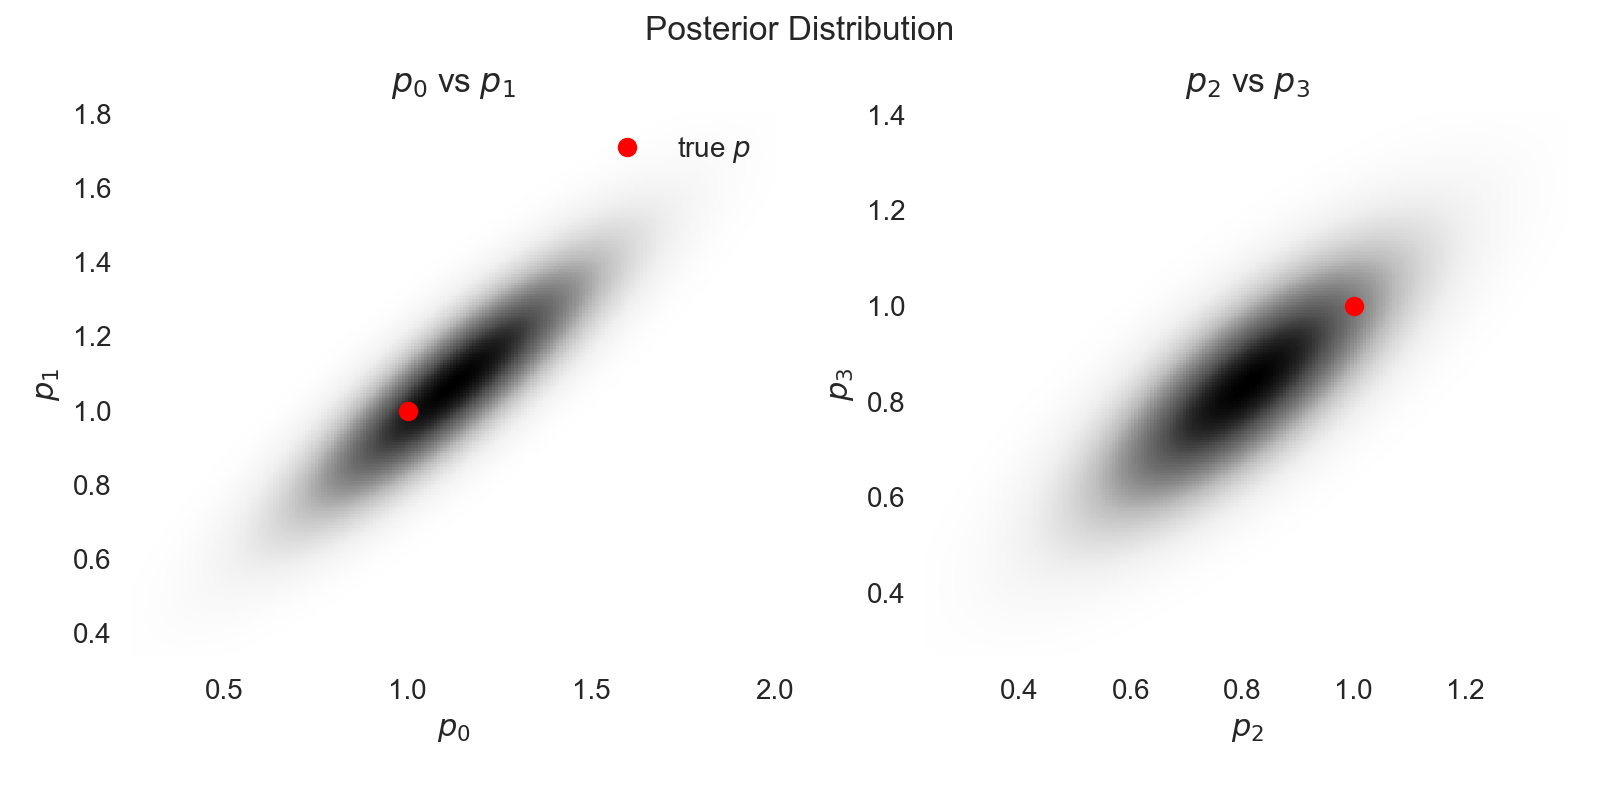

In [19]:
lv_post([1,1,1,1],[2,.5],0.1,10,50)

Settings: n_obs=10, n_sur=200, sigma=0.02, y0=[1, 2.5]
p_true: [1.27932814, 1.21857368, 0.94729893, 0.3227252]
p_hat: [1.3027054  1.23570805 0.89054848 0.3040633 ]
p_std [0.025784   0.02456983 0.06293219 0.02116637]




<IPython.core.display.Javascript object>


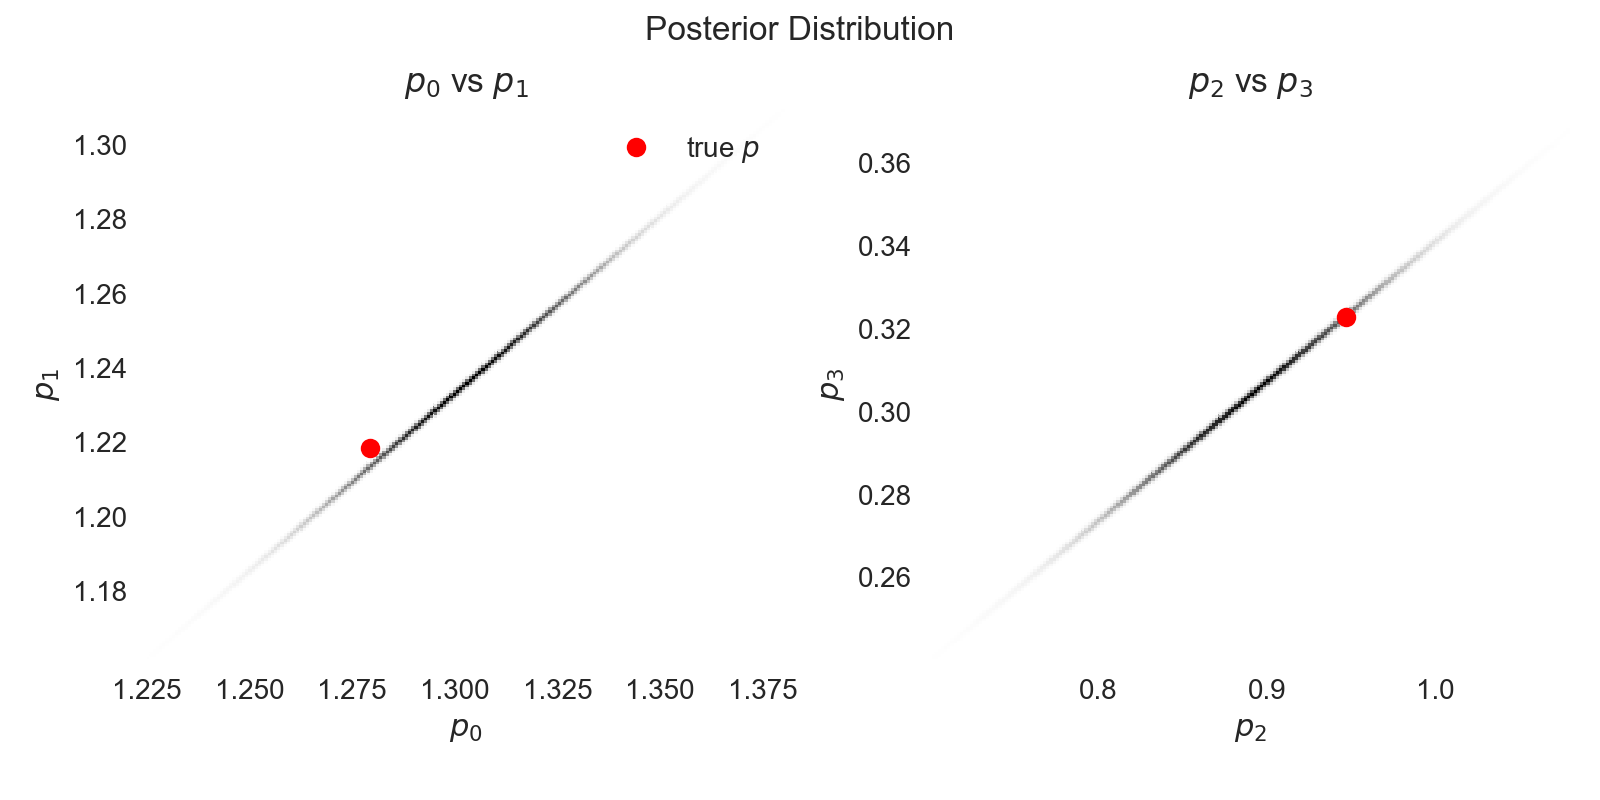

In [29]:
p_true = [1.27932814,1.21857368,0.94729893,0.3227252]
lv_post(p_true,[1,2.5],0.02,10,200)